In [1]:
# should be from pytorch_lightning.loggers import CometLogger
from pytorch_lightning.loggers.comet import CometLogger

In [12]:
#! pip install scikit-image

     |████████████████████████████████| 12.4 MB 8.0 MB/s eta 0:00:01
     |████████████████████████████████| 133 kB 65.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 55.2 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 42.7 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 62.5 MB/s eta 0:00:01


In [2]:
import pytorch_lightning as pl

In [3]:
from torchvision import datasets, transforms
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.patches as patches
from skimage.draw import random_shapes

In [4]:
from torch.optim.lr_scheduler import StepLR

# Homework 2, part 2

1. below you will find a dataloader for the cats dataset (link to dataset file on the course website)

2. the function to add noise to the dataset is built into the dataloader

3. build a model that takes in the 256x256 image, and outputs an image of the same size 

4. use the nn.MSELoss() function

5. train the network

6. submit when you feel your network is doing a decent job at cleaning the images (remember to submit both model weights and source code)

In [5]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn


class CustomDataset(Dataset):
    def __init__(self, path,start_idx, end_idx):
        
        self.data = np.load(path)
        self.data = self.data[start_idx:end_idx]

    def __len__(self):
       
        return len(self.data)
    
    def add_noise(self,y):
        newimg = random_shapes((256, 256),min_shapes=30,max_shapes=42,
                       multichannel=False, min_size=20,max_size=30,allow_overlap=True)[0]/255.0
        x = y.copy()
        x[np.where(newimg < 0.9)] = x[np.where(newimg < 0.9)]+1-newimg[newimg < 0.9]
        return x

    def __getitem__(self, idx):
        
        y = self.data[idx]

        x = torch.FloatTensor(self.add_noise(y))
        # MOD COMMENTED OUT
#         x = torch.FloatTensor(self.add_noise(y)).unsqueeze(0)

        # MOD
        return torch.FloatTensor(x).unsqueeze(0), torch.FloatTensor(y).unsqueeze(0)
        return x, torch.FloatTensor(y).unsqueeze(0)

In [6]:
train_ds = CustomDataset('/storage/cats.npy',0,800)
valid_ds = CustomDataset('/storage/cats.npy',800,1000)

In [7]:
x, y = train_ds[444]

In [8]:
y.shape

torch.Size([1, 256, 256])

In [9]:
x.shape

torch.Size([1, 256, 256])

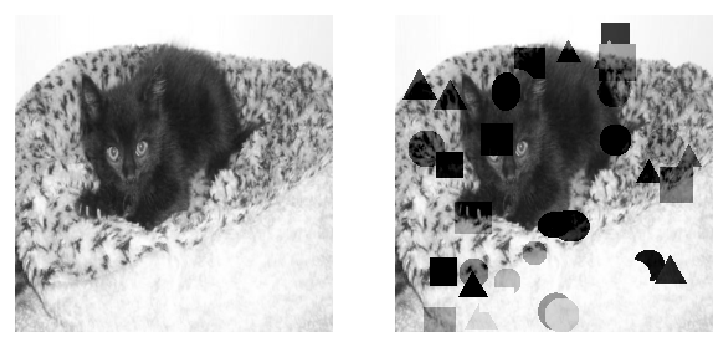

In [10]:
fig,ax = plt.subplots(1,2,figsize=(6,3),dpi=150)

ax[0].imshow(y[0],cmap='gist_yarg',vmin=0,vmax=1)
ax[1].imshow(x[0],cmap='gist_yarg',vmin=0,vmax=1)

for i in range(2):
    ax[i].set_axis_off()

plt.show()

In [11]:
conv_layer = nn.Conv2d(1,512,5,padding=2)

In [12]:
batch_of_one = x.unsqueeze(0)

batch_of_one.shape

torch.Size([1, 1, 256, 256])

In [13]:
# (batch_size, layers, dim1, dim2)
conv_layer(batch_of_one).shape

torch.Size([1, 512, 256, 256])

In [110]:
BATCH_SIZE = 8
LOSS_FUNC = F.mse_loss

In [118]:
# class ImageClassifier(nn.Module):
# https://web.stanford.edu/class/cs331b/2016/projects/zhao.pdf
# https://github.com/pgtgrly/Convolution-Deconvolution-Network-Pytorch/blob/master/Neural_Network_Class.py
# https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/autoencoder/ae-deconv.ipynb
class Denoise(pl.LightningModule):
    def __init__(self):
#         super(LitImgClassifier, self).__init__()       
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, 3, padding=1)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        self.deconv5 = nn.ConvTranspose2d(512, 256, 3, padding=1)
        self.deconv4 = nn.ConvTranspose2d(256, 128, 3, padding=1)
        self.deconv3 = nn.ConvTranspose2d(128,64, 3, padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, 5, padding=2)
        self.deconv1 = nn.ConvTranspose2d(32, 1, 5, padding=2)
        
        self.unpool5 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.unpool4 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.unpool3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.unpool2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.unpool1 = nn.MaxUnpool2d(kernel_size=2, stride=2)

    def forward(self, x):
        out1,ix1 = self.pool1(F.relu(self.conv1(x)))
        out2,ix2 = self.pool2(F.relu(self.conv2(out1)))
        out3,ix3 = self.pool3(F.relu(self.conv3(out2)))
        out4,ix4 = self.pool4(F.relu(self.conv4(out3)))
        out5,ix5 = self.pool5(F.relu(self.conv5(out4)))
        
        out6 = F.relu(self.deconv5(self.unpool5(out5, ix5)))
        out7 = F.relu(self.deconv4(self.unpool4(out4, ix4)))
        out8 = F.relu(self.deconv3(self.unpool3(out3, ix3)))
        out9 = F.relu(self.deconv2(self.unpool2(out2, ix2)))
        out = F.relu(self.deconv1(self.unpool1(out1, ix1)))
        
        return out
    
    def train_dataloader(self):
        dataset_train = CustomDataset('/storage/cats.npy',0,800)
# seemingly CustomDataset handles transformations, tensor...collate_fn=_collate unnecessary                
        return DataLoader(dataset_train,batch_size=BATCH_SIZE,shuffle=True,num_workers=4)

    def val_dataloader(self):
        dataset_val = CustomDataset('/storage/cats.npy',800,1000)
        return DataLoader(dataset_val,batch_size=BATCH_SIZE,shuffle=False,num_workers=4)
    
    def configure_optimizers(self):
        optimizer1 = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler1 = StepLR(optimizer1, step_size=1)
        return [optimizer1], [scheduler1]
        
    
    def training_step(self,batch,batch_idx):
        minib,target = batch
        out = self.forward(minib)
        loss = LOSS_FUNC(out,target)
        # add logging
        logs = {'loss': loss}
        return {'loss': loss, 'log': logs}
#         return loss
    
    def validation_step(self,batch,batch_idx):
        minib, target = batch
        out = self.forward(minib)
        loss = LOSS_FUNC(out,target)
        return {'val_loss': loss}
#         return {'val_loss': loss, 'correct': correct}
        
    
    def validation_epoch_end(self,outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss':avg_loss}
        return {'avg_val_loss':avg_loss, 'log':tensorboard_logs}
        

In [119]:
net = Denoise()

In [120]:
# trainer = pl.Trainer(fast_dev_run=True,gpus=1)

In [121]:
experiment = 'denoise5cnvncd5biasbatch8'

In [122]:
comet_logger = CometLogger(
    api_key='n0QCcEJ7YYeDUkff49kqLEdeJ',
    workspace="ren-e1011",
    project_name="dl1010-a2-2", 
    experiment_name=experiment  
)

CometLogger will be initialized in online mode
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/ren-e1011/dl1010-a2-2/71a51ce461534d68864827e92b83878c
COMET INFO:   Others:
COMET INFO:     Name : denoise5cnvncd5biasbatch8
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     os packages         : 1
COMET INFO: ---------------------------
COMET INFO: old comet version (3.1.8) detected. current: 3.1.9 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/ren-e1011/dl1010-a2-2/54166536619e425899a3aeca49d144be



In [123]:
 trainer = pl.Trainer(max_epochs=20, gpus=1,logger=comet_logger)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]


In [124]:
trainer.fit(net)


   | Name    | Type            | Params
----------------------------------------
0  | conv1   | Conv2d          | 832   
1  | conv2   | Conv2d          | 51 K  
2  | conv3   | Conv2d          | 73 K  
3  | conv4   | Conv2d          | 295 K 
4  | conv5   | Conv2d          | 1 M   
5  | pool1   | MaxPool2d       | 0     
6  | pool2   | MaxPool2d       | 0     
7  | pool3   | MaxPool2d       | 0     
8  | pool4   | MaxPool2d       | 0     
9  | pool5   | MaxPool2d       | 0     
10 | deconv5 | ConvTranspose2d | 1 M   
11 | deconv4 | ConvTranspose2d | 295 K 
12 | deconv3 | ConvTranspose2d | 73 K  
13 | deconv2 | ConvTranspose2d | 51 K  
14 | deconv1 | ConvTranspose2d | 801   
15 | unpool5 | MaxUnpool2d     | 0     
16 | unpool4 | MaxUnpool2d     | 0     
17 | unpool3 | MaxUnpool2d     | 0     
18 | unpool2 | MaxUnpool2d     | 0     
19 | unpool1 | MaxUnpool2d     | 0     


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/ren-e1011/dl1010-a2-2/54166536619e425899a3aeca49d144be
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     epoch [220]   : (0, 19)
COMET INFO:     loss [200]    : (0.02601872943341732, 0.31103384494781494)
COMET INFO:     val_loss [20] : (0.031633492559194565, 0.035277657210826874)
COMET INFO:   Others:
COMET INFO:     Name : denoise5cnvncd5biasbatch8
COMET INFO:   Uploads:
COMET INFO:     code                : 1 (101 KB)
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     os packages         : 1
COMET INFO: ---------------------------


COMET INFO: Uploading stats to Comet before program termination (may take several seconds)


1

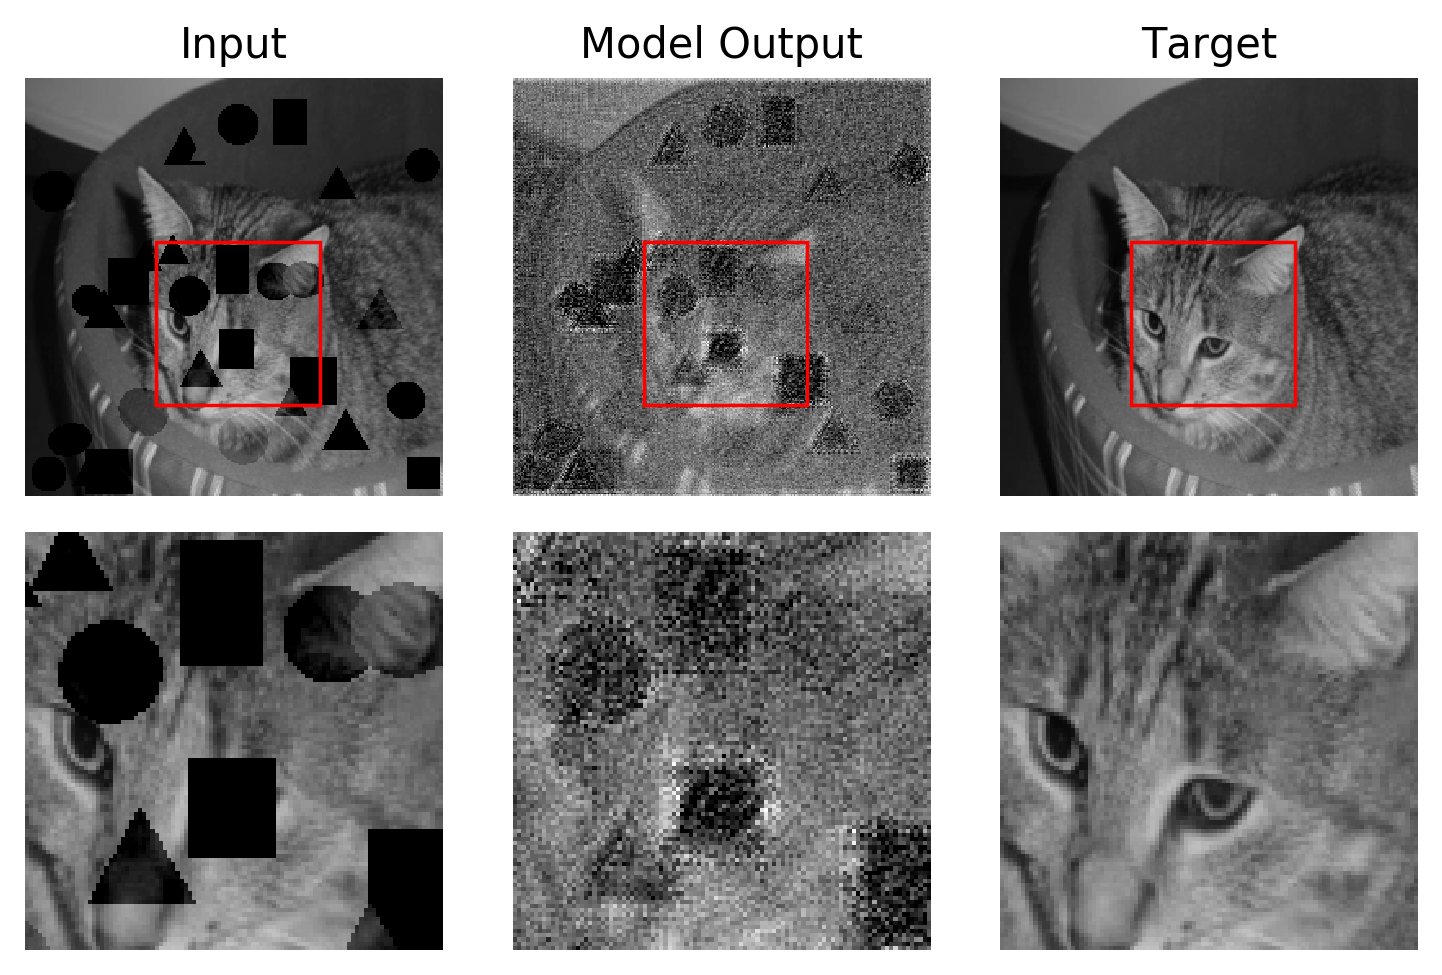

In [125]:
x, y = valid_ds[120]

fig,ax = plt.subplots(2,3,figsize=(6,(6/3)*2),dpi=250)

net.cpu()
net.eval()

input_img = x[0]
model_pred = net(x.unsqueeze(0))[0].cpu().data.numpy()[0]
# model_pred = net(x.unsqueeze(0))

ground_truth = y[0]

patch_xy = [80,100]
patch_hw = [100,100]


ax[0][0].set_title('Input',fontsize=12)
ax[0][1].set_title('Model Output',fontsize=12)
ax[0][2].set_title('Target',fontsize=12)

ax[0][0].imshow(input_img,cmap='gist_yarg',vmin=0,vmax=1)
ax[0][1].imshow(model_pred,cmap='gist_yarg',vmin=0,vmax=1)
ax[0][2].imshow(ground_truth,cmap='gist_yarg',vmin=0,vmax=1)


for i in range(0,3):
    rect = patches.Rectangle(patch_xy,patch_hw[0],patch_hw[1],linewidth=1,edgecolor='r',facecolor='none')
    ax[0][i].add_patch(rect)


input_img    = input_img[patch_xy[1]:patch_xy[1]+patch_hw[1],patch_xy[0]:patch_xy[0]+patch_hw[0]] 
model_pred   = model_pred[patch_xy[1]:patch_xy[1]+patch_hw[1],patch_xy[0]:patch_xy[0]+patch_hw[0]]    
ground_truth = ground_truth[patch_xy[1]:patch_xy[1]+patch_hw[1],patch_xy[0]:patch_xy[0]+patch_hw[0]] 


ax[1][0].imshow(input_img,cmap='gist_yarg',vmin=0,vmax=1)
ax[1][1].imshow(model_pred,cmap='gist_yarg',vmin=0,vmax=1)
ax[1][2].imshow(ground_truth,cmap='gist_yarg',vmin=0,vmax=1)


for i in range(3):
    for j in range(2):
        ax[j][i].set_axis_off()

plt.tight_layout()
plt.show()

In [126]:
torch.save(net.state_dict(),experiment+'.pt')